<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/Time_Series_Forecasting_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Functions

In [ ]:
!pip install torchmetrics torchinfo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

import itertools
import math

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torchmetrics
import torchinfo

from torch.utils.data import Dataset, DataLoader

In [ ]:
def generate_time_series(n_steps = 120, trend_min = 1.0, trend_max = 5.0, trend_noise_scale = 0.05, alpha = 1., num_cycles = 0, season_noise_scale = 0.):

    trend = np.linspace(trend_min, trend_max, n_steps) + trend_noise_scale * np.random.randn(n_steps)
    trend = trend.astype(np.float32)
    if num_cycles == 0:
        seasonality = 0
    else:
        seasonality = np.sin(np.linspace(0, n_steps, n_steps) * 2 * np.pi / (n_steps / num_cycles)) + season_noise_scale * np.random.randn(n_steps)
        seasonality = seasonality.astype(np.float32)
    total = trend + alpha * seasonality

    return {"trend": trend, "seasonality": seasonality, "total": total}

In [ ]:
def plot_time_series(time_series, n_steps = None):
    fig, ax = plt.subplots(1, 3, figsize = (10, 3))
    if n_steps is None:
        ax[0].plot(time_series["trend"])
        ax[0].set_title("Trend")
        ax[1].plot(time_series["seasonality"])
        ax[1].set_title("Seasonality")
        ax[2].plot(time_series["total"])
        ax[2].set_title("Time Series")
    else:
        ax[0].plot(n_steps, time_series["trend"])
        ax[0].set_title("Trend")
        ax[1].plot(n_steps, time_series["seasonality"])
        ax[1].set_title("Seasonality")
        ax[2].plot(n_steps, time_series["total"])
        ax[2].set_title("Time Series")
    fig.tight_layout()
    plt.show()

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, seq, window = 12, differencing = False, scaler = None):
        self.seq = seq.copy()
        self.window = window
        self.inputs = []
        self.labels = []

        if scaler is not None:
            self.scaler = scaler
            self.seq = (self.scaler.fit_transform(self.seq.reshape(-1, 1))).reshape(-1)
        else:
            self.scaler = None

        if differencing:
            diff = self.seq[1:] - self.seq[: -1]
            for t in range(len(diff) - window):
                input = diff[t: t + window]
                self.inputs.append(input)
                label = diff[t + window]
                self.labels.append(label)
        else:
            for t in range(len(self.seq) - window):
                input = self.seq[t: t + window]
                self.inputs.append(input)
                label = self.seq[t + window]
                self.labels.append(label)

        self.inputs = np.array(self.inputs).reshape(-1, window, 1)
        self.labels = np.array(self.labels).reshape(-1, 1)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size = hidden_size, nonlinearity = activation, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        return x

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.LSTM(1, hidden_size = hidden_size, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        return x

In [ ]:
class RNNDelta(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size = hidden_size, nonlinearity = activation, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        last_input = x[:, -1, :]
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        out = last_input + x
        return out

In [ ]:
def train_epoch(model, train_loader, loss_func, optimizer, device, clip_norm):
    epoch_loss = torchmetrics.MeanMetric().to(device)
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        if clip_norm:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss(loss)

    return epoch_loss.compute()

In [ ]:
def train_model(model, train_loader, loss_func, optimizer, device, num_epochs = 100, clip_norm = False):
    train_epoch_losses = []
    for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
        train_epoch_loss = train_epoch(model, train_loader, loss_func, optimizer, device, clip_norm)
        train_epoch_losses.append(train_epoch_loss)
        if (epoch +1) % 10 == 0:
            print("Epoch: {}. Train loss: {:.3f}".format(epoch + 1, train_epoch_loss))

    return train_epoch_losses

In [ ]:
def forecast(model, input, time_series, split, differencing = False, averaging_steps = None, display_seq = False):
    train_step = int(len(time_series['total']) * split)
    forecast_step = len(time_series['total']) - train_step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # last_train = input.__getitem__(-1)[0]
        if differencing:
            # We need the last 'window' differences.
            # This requires the last 'window + 1' raw points.
            last_raw_window = input.seq[-(input.window + 1):]
            last_input_data = last_raw_window[1:] - last_raw_window[:-1] # Calculate diff manually
        else:
            # If no differencing, just take the raw points
            last_input_data = input.seq[-input.window:]

        input_seq = last_input_data.reshape(1, -1, 1)  # Last sequence

        input_tensor = torch.from_numpy(input_seq)
        preds = []

        for _ in range(forecast_step):
            output = model(input_tensor)
            scaler = input.scaler
            if scaler is not None:
                pred = float((scaler.inverse_transform(output.cpu().numpy()))[0, 0])
            else:
                pred = output.item()
            preds.append(pred)
            input_tensor = torch.cat((input_tensor[:, 1:, :], output.reshape(1, 1, 1)), dim = 1)

    if differencing:
        if averaging_steps is None:
            preds_original = [input.seq[-1].item()]
        else:
            preds_original = [input.seq[-averaging_steps:].mean().item()]
        for pred in preds:
            preds_next = preds_original[-1] + pred
            preds_original.append(preds_next)
        preds = preds_original[1:]
    # Plot the results
    plt.figure(figsize=(10, 6))
    if display_seq:
        print(time_series['total'])
        print(preds)
    plt.plot(range(train_step), time_series['total'][: train_step], label='Train Data', color='blue')
    plt.plot(range(train_step, train_step + forecast_step), time_series['total'][train_step :], label='Test Data', color='green')
    plt.plot(range(train_step, train_step + forecast_step), preds, label='Forecast', color='red')
    plt.legend()
    plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Perfect Linear Trend

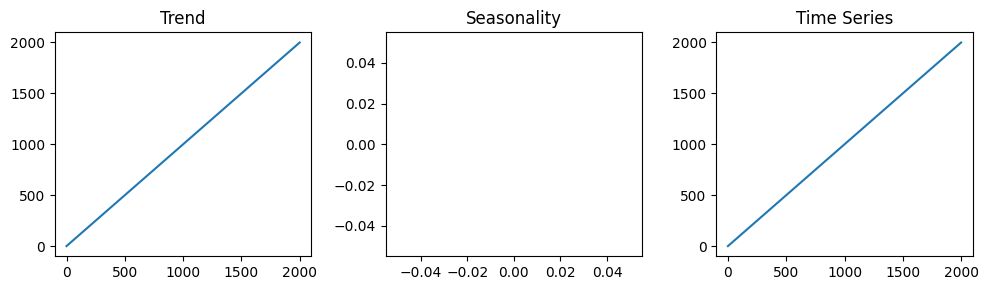

In [ ]:
n_steps = 2000
split = 0.5

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 1999.0, trend_noise_scale = 0., num_cycles = 0)
plot_time_series(time_series)

In [ ]:
window = 10
scaler = None
differencing = True
split_step = int(n_steps * split)

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")

In [ ]:
torchinfo.summary(model, (window, 1), batch_dim = 0)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [1, 1]                    --
├─RNN: 1-1                               [1, 10, 6]                54
├─Linear: 1-2                            [1, 1]                    7
Total params: 61
Trainable params: 61
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.000
Epoch: 20. Train loss: 0.000
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


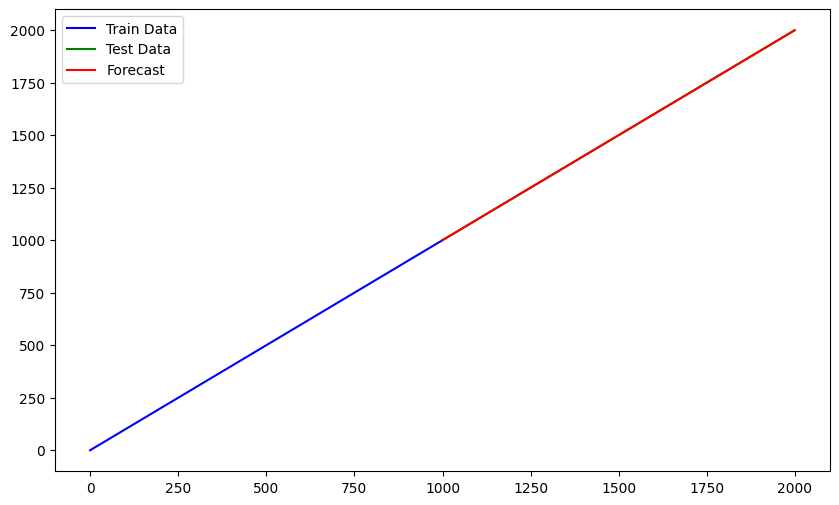

In [ ]:
forecast(model, train_dataset, time_series, split = split, differencing = differencing)

# Linear Trend with Noise

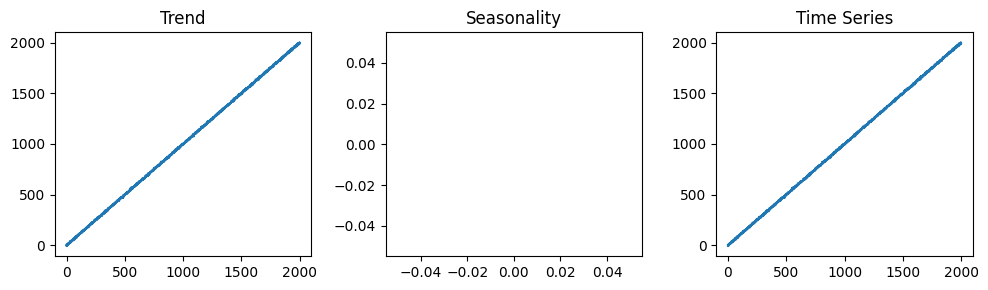

In [ ]:
n_steps = 2000
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 1999.0, trend_noise_scale = 5.0, num_cycles = 0)
plot_time_series(time_series)

In [ ]:
window = 15
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")

In [ ]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 27.850
Epoch: 20. Train loss: 26.553
Epoch: 30. Train loss: 26.465
Epoch: 40. Train loss: 26.416
Epoch: 50. Train loss: 26.378
Epoch: 60. Train loss: 26.337
Epoch: 70. Train loss: 26.272
Epoch: 80. Train loss: 26.215
Epoch: 90. Train loss: 26.171
Epoch: 100. Train loss: 26.134


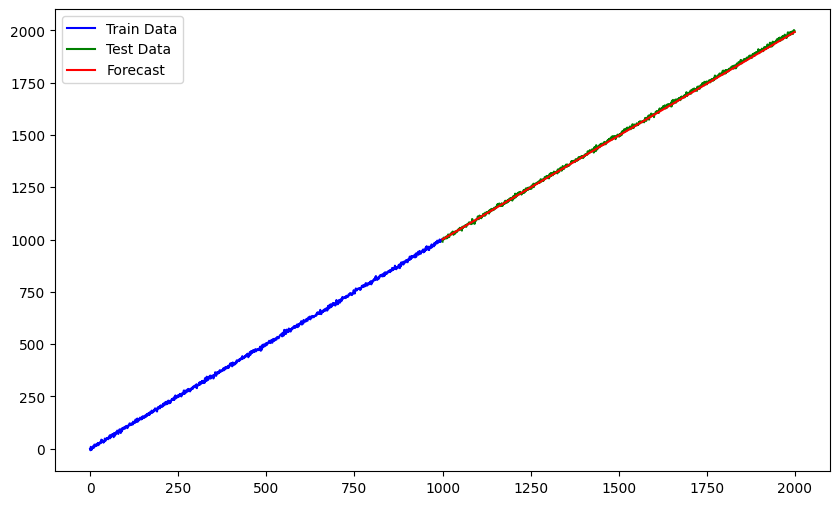

In [ ]:
forecast(model, train_dataset, time_series, split = split, differencing = differencing)

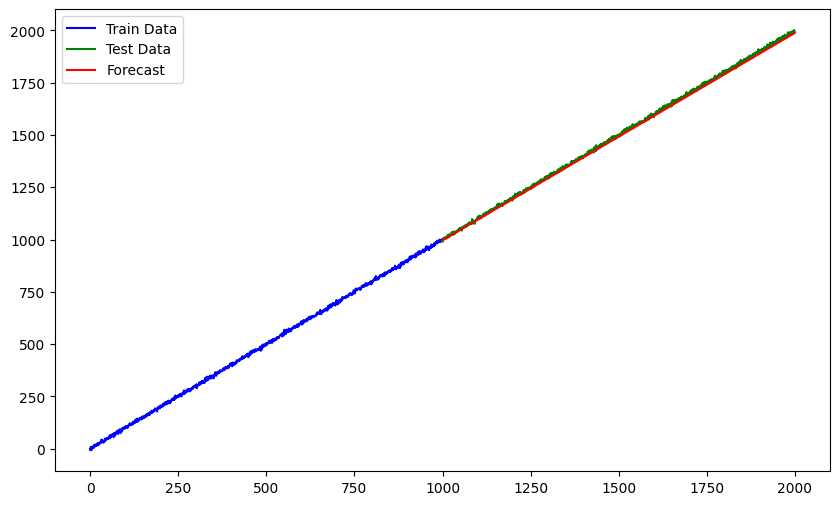

In [ ]:
forecast(model, train_dataset, time_series, split = split, differencing = differencing, averaging_steps = 5)

# Perfect Sine Curve

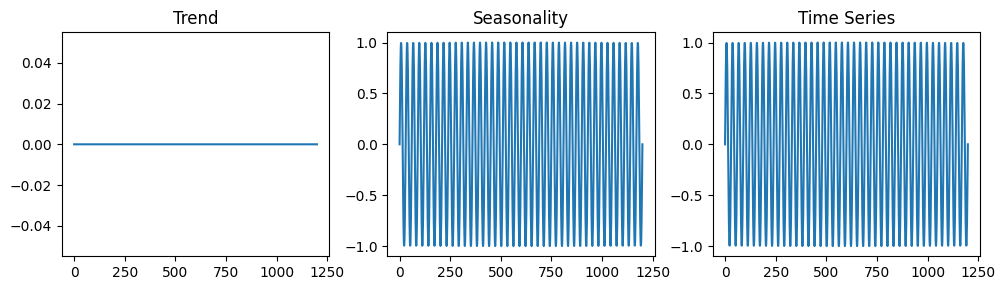

In [ ]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 0.0, trend_noise_scale = 0.0, num_cycles = 40)
plot_time_series(time_series)

In [ ]:
window = 15
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")

In [ ]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.000
Epoch: 20. Train loss: 0.000
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


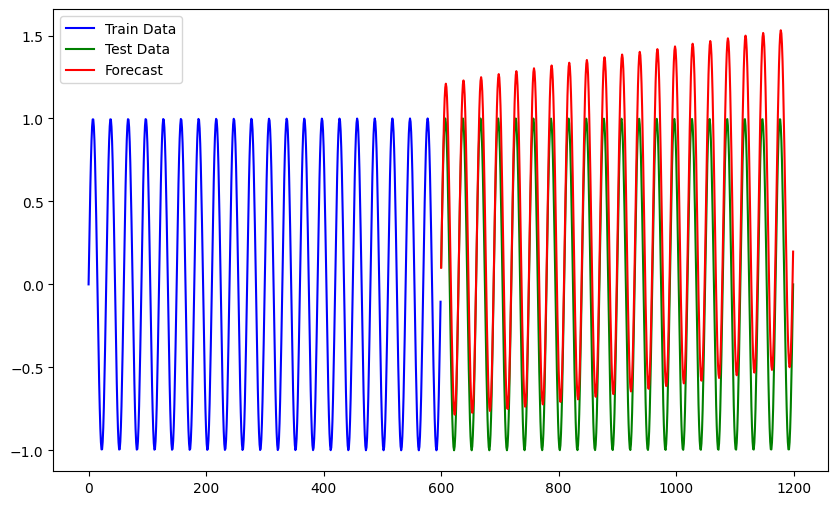

In [ ]:
forecast(model, train_dataset, time_series, split = split, differencing = differencing)

In [ ]:
window = 10
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.025
Epoch: 20. Train loss: 0.000
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


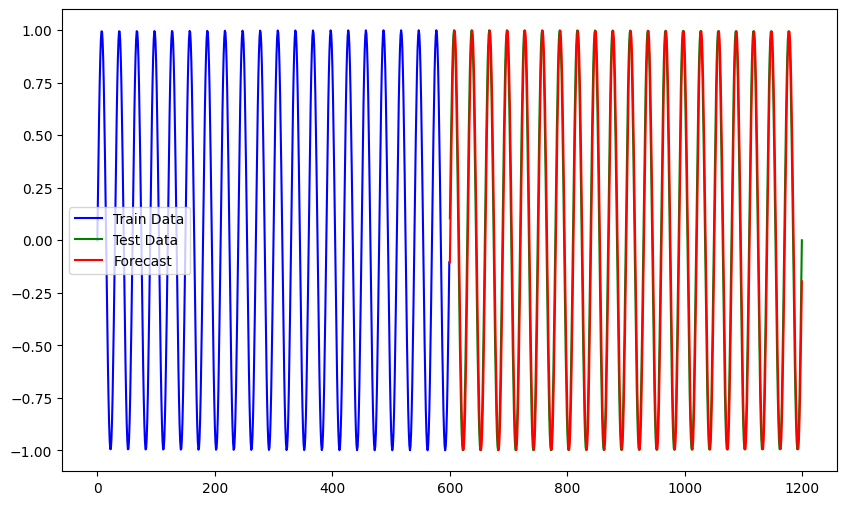

In [ ]:
forecast(model, train_dataset, time_series, split = split, differencing = differencing)

# Sine Curve with Noise

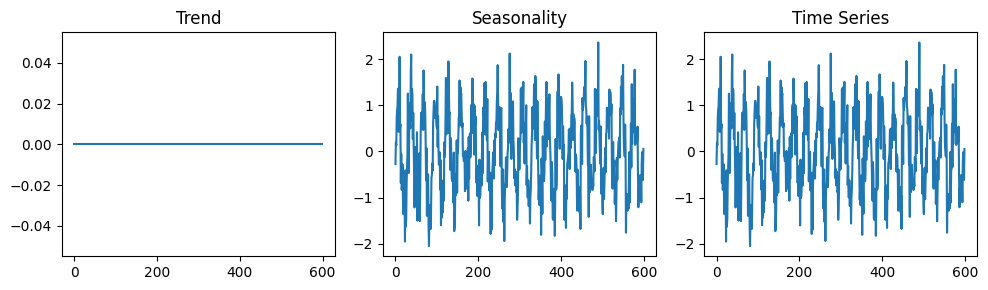

In [ ]:
time_series = generate_time_series(n_steps = 600, trend_min = 0.0, trend_max = 0.0, trend_noise_scale = 0.0, num_cycles = 20, season_noise_scale = 0.5)
plot_time_series(time_series)

In [ ]:
window = 15
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.427
Epoch: 20. Train loss: 0.326
Epoch: 30. Train loss: 0.274
Epoch: 40. Train loss: 0.257
Epoch: 50. Train loss: 0.251
Epoch: 60. Train loss: 0.250
Epoch: 70. Train loss: 0.252
Epoch: 80. Train loss: 0.247
Epoch: 90. Train loss: 0.246
Epoch: 100. Train loss: 0.245


[-0.27473328  0.19049698  0.13424705  0.73145866  0.913419    0.97344846
  1.3588877   1.3472785   0.42374086  0.6809267   2.0508232   0.49410686
  0.5911402  -0.6829995  -0.05198535 -0.8299457  -0.7310504  -0.27703974
 -0.97885334 -1.3575562  -1.2237145  -0.65105516 -0.8403808  -1.9517329
 -0.4089394  -1.631131   -1.4618506  -0.70196855 -0.37098226 -0.0484061
  1.2521791   0.25063685 -0.4670716   0.36566067  1.0499282   0.63185
  0.4988067   1.6488937   2.0996065   0.67211396  1.3510036   1.2147537
  0.26765674  0.8365319   0.27088016 -0.43911687 -1.2138115  -0.76043284
  0.09870151 -0.3267081  -1.0164518  -0.9869782   0.41574892 -1.4990177
 -0.68836135 -1.453599   -1.3577254  -0.5167064  -0.03519213 -1.5094572
 -0.60997784  0.39309898  0.8358126   0.492471    0.8432295   0.69292665
  1.2405692   0.4649228   1.7538332   1.0286396   1.0068225   1.069053
  0.82740676  0.20214055 -0.62477934  0.06970833 -1.3931994  -0.6992455
 -0.515247   -0.49631506 -1.6038792  -2.0505896  -1.4584898  -

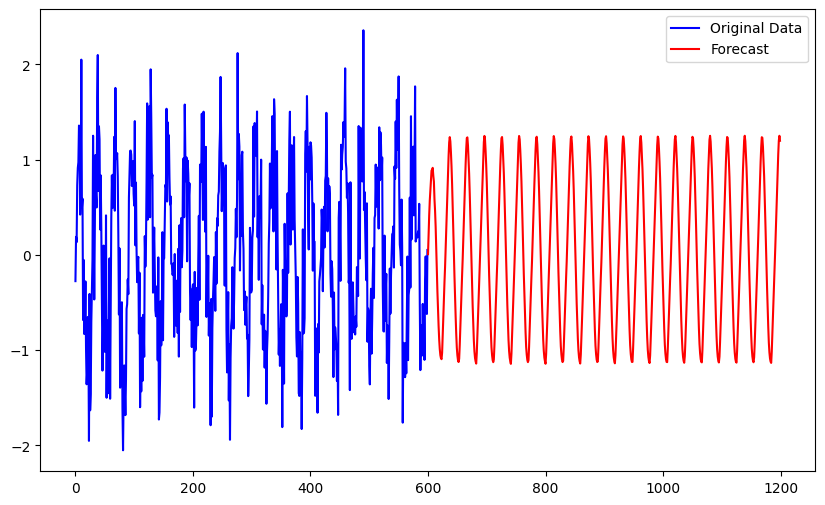

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 600, differencing = differencing)

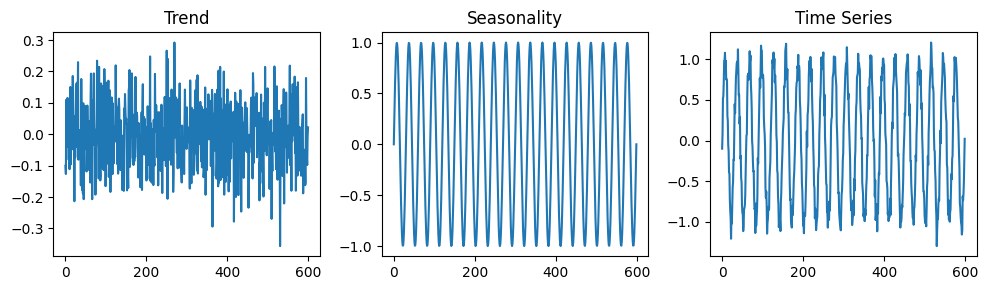

In [ ]:
time_series = generate_time_series(n_steps = 600, trend_min = 0.0, trend_max = 0.0, trend_noise_scale = 0.1, num_cycles = 20, season_noise_scale = 0.0)
plot_time_series(time_series)

In [ ]:
window = 20
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.052
Epoch: 20. Train loss: 0.015
Epoch: 30. Train loss: 0.014
Epoch: 40. Train loss: 0.014
Epoch: 50. Train loss: 0.014
Epoch: 60. Train loss: 0.014
Epoch: 70. Train loss: 0.014
Epoch: 80. Train loss: 0.014
Epoch: 90. Train loss: 0.014
Epoch: 100. Train loss: 0.013


[-0.10020219  0.08171508  0.5172022   0.548842    0.716985    0.9826431
  0.9874469   1.0807219   0.9130303   0.98169535  0.75308686  0.7569929
  0.7350168   0.30667934  0.24043913 -0.05451173 -0.12830633 -0.39335364
 -0.4072911  -0.7227878  -0.86583567 -0.94983286 -1.2085565  -0.9368447
 -1.0219837  -0.8006612  -0.5787436  -0.5086363  -0.23369218 -0.23881918
  0.09218372  0.44821     0.33594146  0.5726417   0.7643406   0.856436
  0.9491098   0.97102934  0.8303054   1.1227641   0.88423574  0.5563048
  0.56879425  0.20485891  0.29151404 -0.22246456 -0.18929239 -0.46984935
 -0.51075906 -0.79812807 -0.89078027 -0.90729195 -1.1148642  -1.0551329
 -0.8536341  -0.83210605 -0.79979455 -0.6850038  -0.39593533 -0.14594764
  0.06033712  0.07489815  0.53415793  0.7986301   0.80890393  0.8273136
  0.75109065  0.94483083  1.0994892   0.97793686  1.0473455   0.6924702
  0.58072585  0.39767462 -0.00977629 -0.07624365 -0.25983688 -0.38061166
 -0.3754027  -0.7087917  -0.8451362  -0.83141065 -1.1380477 

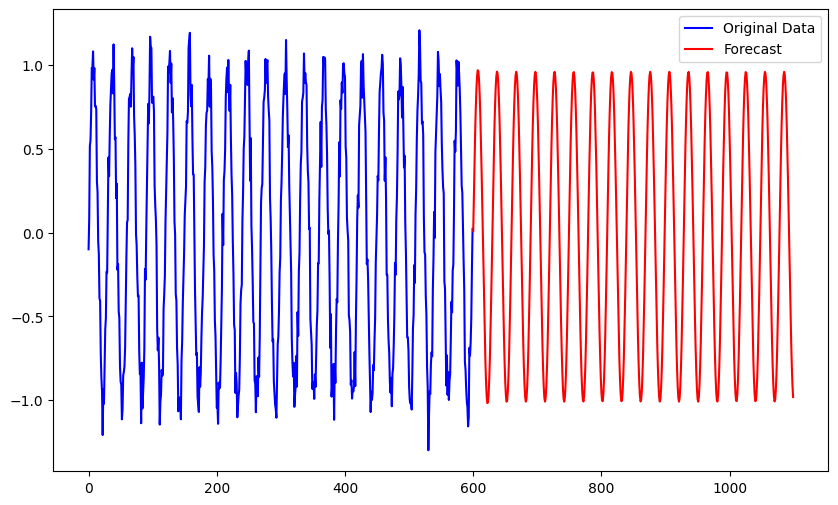

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)

# Perfect Sine Curve with Linear Trend

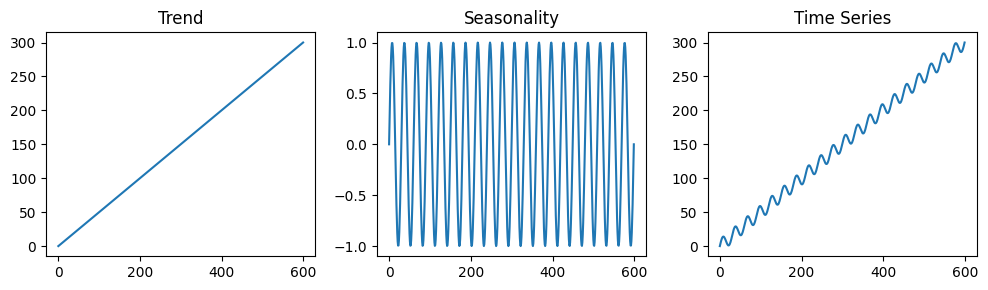

In [ ]:
time_series = generate_time_series(n_steps = 600, trend_min = 0.0, trend_max = 300.0, trend_noise_scale = 0., alpha = 10., num_cycles = 20)
plot_time_series(time_series)

In [ ]:
window = 15
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.088
Epoch: 20. Train loss: 0.003
Epoch: 30. Train loss: 0.001
Epoch: 40. Train loss: 0.001
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


[  0.           2.5833714    5.0754232    7.3888397    9.444139
  11.173155    12.522036    13.45359     13.948934    14.0083065
  13.651066    12.91484     11.853873    10.536652     9.042897
   7.460074     5.87955      4.3925953    3.0863724    2.040123
   1.3216867    0.98453045   1.0653982    1.5827074    2.5357342
   3.9046507    5.6513906    7.721321    10.045637    12.544378
  15.129934    17.710892    20.196033    22.498352    24.538849
  26.250008    27.578758    28.488794    28.962173    29.0001
  28.622868    27.868988    26.793476    25.465454    23.96512
  22.380228    20.802233    19.322294    18.027271    16.995909
  16.295399    15.978416    16.080826    16.620098    17.594547
  18.983404    20.74773     22.832119    25.167135    27.672346
  30.259857    32.838173    35.31619     37.60721     39.632732
  41.3259      42.63443     43.522903    43.97432     43.990845
  43.593727    42.822327    41.732445    40.393826    38.887135
  37.300396    35.72516     34.252457    

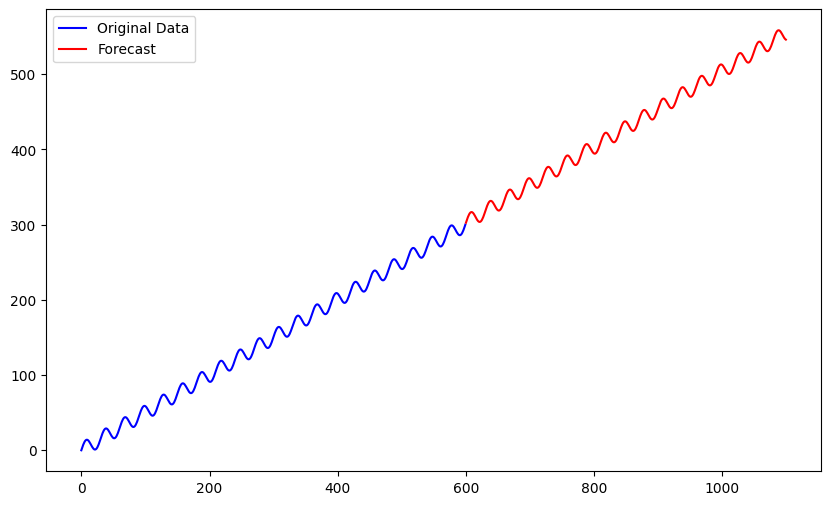

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)

# Sine Curve with Linear Trend and Noise

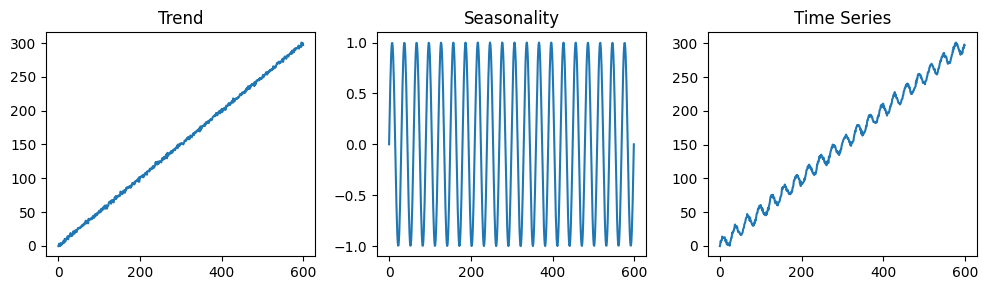

In [ ]:
time_series = generate_time_series(n_steps = 600, trend_min = 0.0, trend_max = 300.0, trend_noise_scale = 1.5, alpha = 10., num_cycles = 20)
plot_time_series(time_series)

In [ ]:
window = 15
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 6.773
Epoch: 20. Train loss: 5.954
Epoch: 30. Train loss: 5.297
Epoch: 40. Train loss: 4.222
Epoch: 50. Train loss: 3.920
Epoch: 60. Train loss: 3.806
Epoch: 70. Train loss: 3.748
Epoch: 80. Train loss: 3.696
Epoch: 90. Train loss: 3.659
Epoch: 100. Train loss: 3.640


[-4.70473289e-01  2.03786922e+00  7.22103834e+00  5.79844904e+00
  8.46097660e+00  8.60364246e+00  1.36741982e+01  1.13000793e+01
  1.15965157e+01  1.16181583e+01  1.15262556e+01  1.22549992e+01
  1.27014599e+01  9.05741405e+00  6.34416771e+00  8.62625885e+00
  8.26331711e+00  2.06843948e+00  3.55922413e+00  2.23163319e+00
  1.12952423e+00  2.00555325e+00  1.69582176e+00  4.28094196e+00
  1.01623535e-01  4.62361813e+00  6.34276819e+00  8.92435169e+00
  1.16932163e+01  1.18991489e+01  1.89975777e+01  1.79906597e+01
  2.10142136e+01  2.06466675e+01  2.22631283e+01  2.47545929e+01
  2.76001339e+01  3.14857216e+01  2.80173798e+01  2.85907898e+01
  2.68286991e+01  2.87080822e+01  2.89112015e+01  2.53254299e+01
  2.23548145e+01  2.03509808e+01  2.14434624e+01  2.00665970e+01
  2.02583122e+01  1.79027500e+01  1.69220505e+01  1.72594757e+01
  1.61701508e+01  1.62333450e+01  1.80874252e+01  1.87257042e+01
  2.06055489e+01  2.43030396e+01  2.60755730e+01  2.69869556e+01
  3.16055984e+01  3.31126

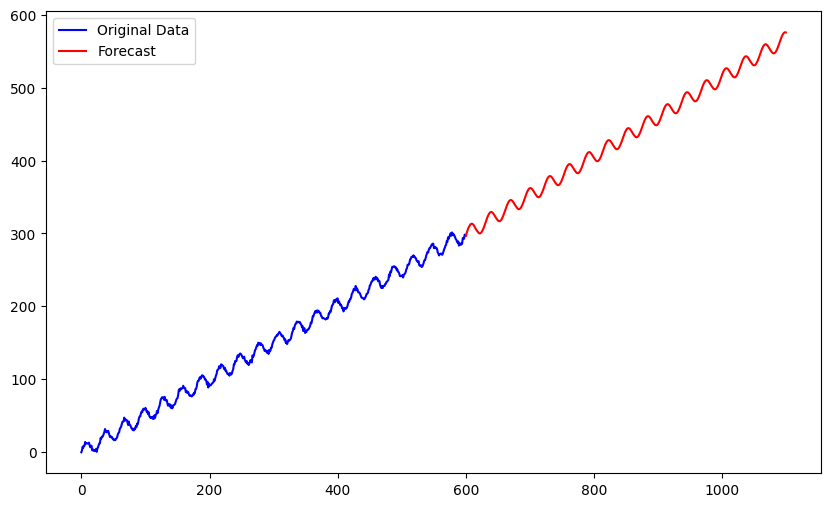

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing, averaging = True)

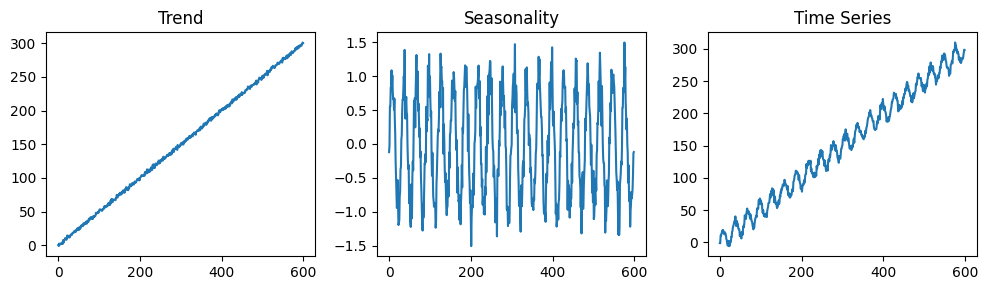

In [ ]:
time_series = generate_time_series(n_steps = 600, trend_min = 0.0, trend_max = 300.0, trend_noise_scale = 1.5, alpha = 15., num_cycles = 20, season_noise_scale = 0.2)
plot_time_series(time_series)

In [ ]:
window = 15
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 25.635
Epoch: 20. Train loss: 23.294
Epoch: 30. Train loss: 18.296
Epoch: 40. Train loss: 17.527
Epoch: 50. Train loss: 16.978
Epoch: 60. Train loss: 16.583
Epoch: 70. Train loss: 16.396
Epoch: 80. Train loss: 16.310
Epoch: 90. Train loss: 16.262
Epoch: 100. Train loss: 16.242


[ -1.1857309  -1.4468741  10.976236   10.478403   13.6571865  14.944479
  18.295048   15.551312   19.171986   14.321505   14.314096   12.487858
  15.727297   14.321293   13.250122   10.04654     4.9776864   3.4935722
  -1.6450052  -4.7914143  -5.1704845   2.317295    1.0095625  -5.844426
  -5.4280634  -2.590519    2.3648033   1.073245    8.5890665   8.265848
  16.505709   18.01305    23.775608   25.343172   27.735603   30.557917
  33.14007    32.11177    40.213898   31.712755   25.23883    28.596672
  32.90493    27.445885   28.083443   22.528112   20.332209   20.182457
  18.443699    9.668005   13.173303   14.628837    6.845392    6.032442
  16.117764   14.740053   11.784176   22.975452   25.822372   23.431637
  30.109522   41.867706   39.198883   40.66655    36.317684   45.314804
  48.38331    52.399757   45.14469    46.255894   48.628654   43.796047
  45.6866     40.770454   36.92075    43.19693    35.941727   36.391735
  32.93924    31.445465   26.919792   23.815708   20.205229   2

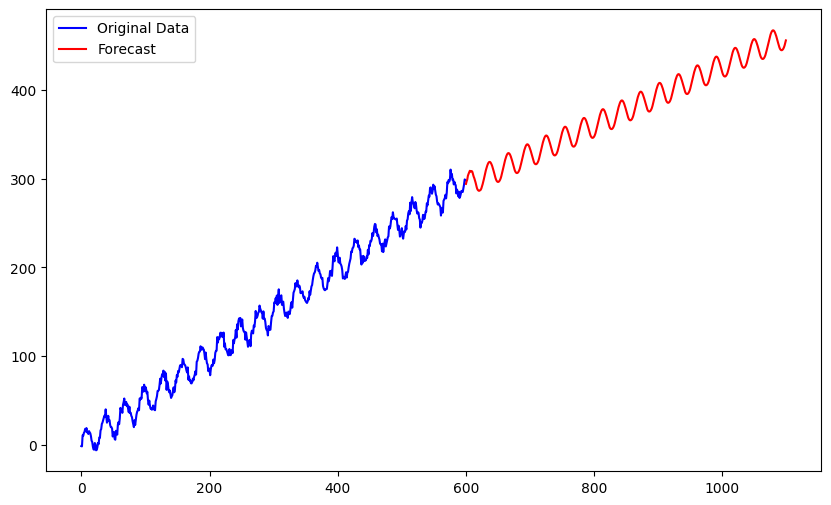

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing, averaging = True)

# Other Time Series

In [ ]:
def generate_time_series_2(start = 0, end = 10, n_steps = 120, trend_noise_scale = 0.0, alpha = 1., ):

    trend = trend_noise_scale * np.random.randn(n_steps)
    trend = trend.astype(np.float32)
    time_steps = np.linspace(start, end, n_steps)
    seasonality = np.exp(-0.1 * time_steps) * np.cos(4 * np.pi * time_steps)
    seasonality = seasonality.astype(np.float32)
    total = trend + alpha * seasonality

    return {"trend": trend, "seasonality": seasonality, "total": total}

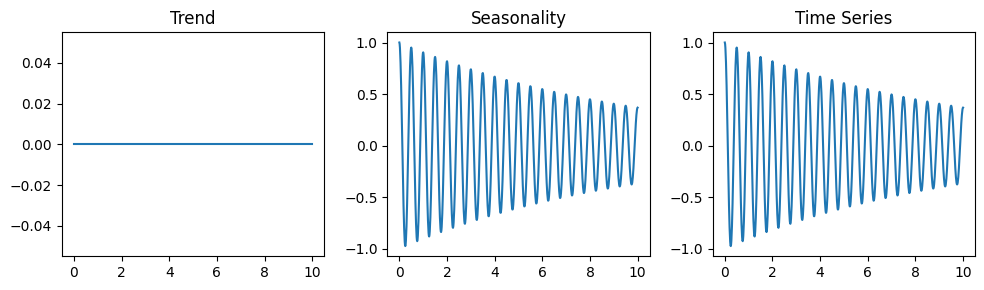

In [ ]:
end = 10
n_steps = 800
time_series = generate_time_series_2(end = end, n_steps = n_steps, trend_noise_scale = 0.0, alpha = 1., )
plot_time_series(time_series, n_steps = np.linspace(0, end, n_steps))

In [ ]:
window = 15
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.043
Epoch: 20. Train loss: 0.000
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


[ 1.00000000e+00  9.86422241e-01  9.48557615e-01  8.87400448e-01
  8.04516792e-01  7.02004552e-01  5.82440317e-01  4.48814571e-01
  3.04457128e-01  1.52954027e-01 -1.94149977e-03 -1.56401917e-01
 -3.06620002e-01 -4.48902667e-01 -5.79761684e-01 -6.95999146e-01
 -7.94785857e-01 -8.73729646e-01 -9.30933833e-01 -9.65042293e-01
 -9.75271881e-01 -9.61429954e-01 -9.23918068e-01 -8.63720298e-01
 -7.82377422e-01 -6.81948006e-01 -5.64955890e-01 -4.34326917e-01
 -2.93315947e-01 -1.45425647e-01  5.68048470e-03  1.56268790e-01
  3.02627742e-01  4.41159338e-01  5.68467557e-01  6.81441665e-01
  7.77332008e-01  8.53817046e-01  9.09059525e-01  9.41750586e-01
  9.51140463e-01  9.37056065e-01  8.99903178e-01  8.40655565e-01
  7.60829270e-01  6.62443817e-01  5.47971427e-01  4.20274734e-01
  2.82535136e-01  1.38173819e-01 -9.23333783e-03 -1.56044319e-01
 -2.98640937e-01 -4.33517873e-01 -5.57368994e-01 -6.67168260e-01
 -7.60243654e-01 -8.34342062e-01 -8.87684107e-01 -9.19006467e-01
 -9.27591860e-01 -9.13285

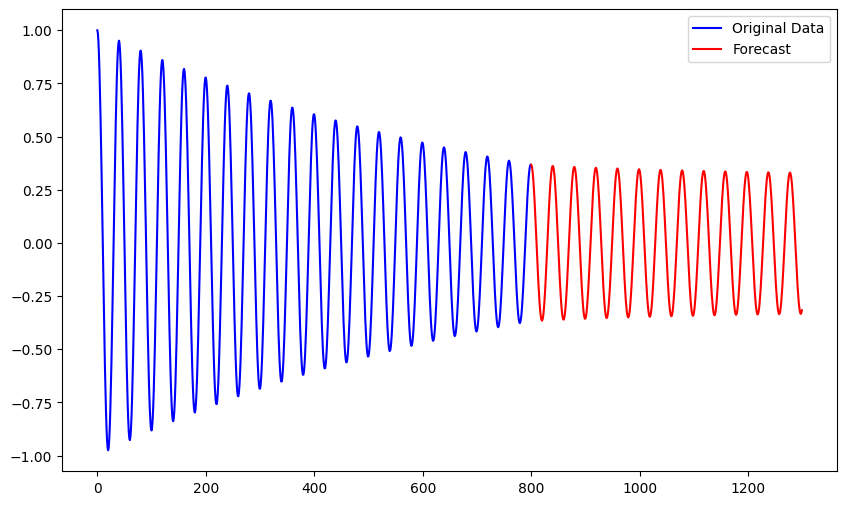

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)

In [ ]:
window = 30
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.001
Epoch: 20. Train loss: 0.000
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


[ 1.00000000e+00  9.86422241e-01  9.48557615e-01  8.87400448e-01
  8.04516792e-01  7.02004552e-01  5.82440317e-01  4.48814571e-01
  3.04457128e-01  1.52954027e-01 -1.94149977e-03 -1.56401917e-01
 -3.06620002e-01 -4.48902667e-01 -5.79761684e-01 -6.95999146e-01
 -7.94785857e-01 -8.73729646e-01 -9.30933833e-01 -9.65042293e-01
 -9.75271881e-01 -9.61429954e-01 -9.23918068e-01 -8.63720298e-01
 -7.82377422e-01 -6.81948006e-01 -5.64955890e-01 -4.34326917e-01
 -2.93315947e-01 -1.45425647e-01  5.68048470e-03  1.56268790e-01
  3.02627742e-01  4.41159338e-01  5.68467557e-01  6.81441665e-01
  7.77332008e-01  8.53817046e-01  9.09059525e-01  9.41750586e-01
  9.51140463e-01  9.37056065e-01  8.99903178e-01  8.40655565e-01
  7.60829270e-01  6.62443817e-01  5.47971427e-01  4.20274734e-01
  2.82535136e-01  1.38173819e-01 -9.23333783e-03 -1.56044319e-01
 -2.98640937e-01 -4.33517873e-01 -5.57368994e-01 -6.67168260e-01
 -7.60243654e-01 -8.34342062e-01 -8.87684107e-01 -9.19006467e-01
 -9.27591860e-01 -9.13285

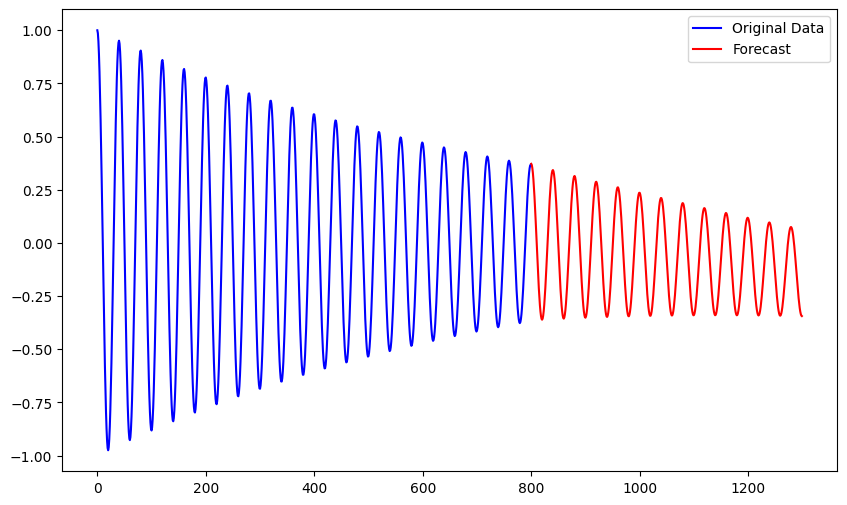

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)

In [ ]:
window = 50
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [ ]:
model = SimpleLSTM(device = device, hidden_size = 12, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.004
Epoch: 20. Train loss: 0.001
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


[ 1.00000000e+00  9.86422241e-01  9.48557615e-01  8.87400448e-01
  8.04516792e-01  7.02004552e-01  5.82440317e-01  4.48814571e-01
  3.04457128e-01  1.52954027e-01 -1.94149977e-03 -1.56401917e-01
 -3.06620002e-01 -4.48902667e-01 -5.79761684e-01 -6.95999146e-01
 -7.94785857e-01 -8.73729646e-01 -9.30933833e-01 -9.65042293e-01
 -9.75271881e-01 -9.61429954e-01 -9.23918068e-01 -8.63720298e-01
 -7.82377422e-01 -6.81948006e-01 -5.64955890e-01 -4.34326917e-01
 -2.93315947e-01 -1.45425647e-01  5.68048470e-03  1.56268790e-01
  3.02627742e-01  4.41159338e-01  5.68467557e-01  6.81441665e-01
  7.77332008e-01  8.53817046e-01  9.09059525e-01  9.41750586e-01
  9.51140463e-01  9.37056065e-01  8.99903178e-01  8.40655565e-01
  7.60829270e-01  6.62443817e-01  5.47971427e-01  4.20274734e-01
  2.82535136e-01  1.38173819e-01 -9.23333783e-03 -1.56044319e-01
 -2.98640937e-01 -4.33517873e-01 -5.57368994e-01 -6.67168260e-01
 -7.60243654e-01 -8.34342062e-01 -8.87684107e-01 -9.19006467e-01
 -9.27591860e-01 -9.13285

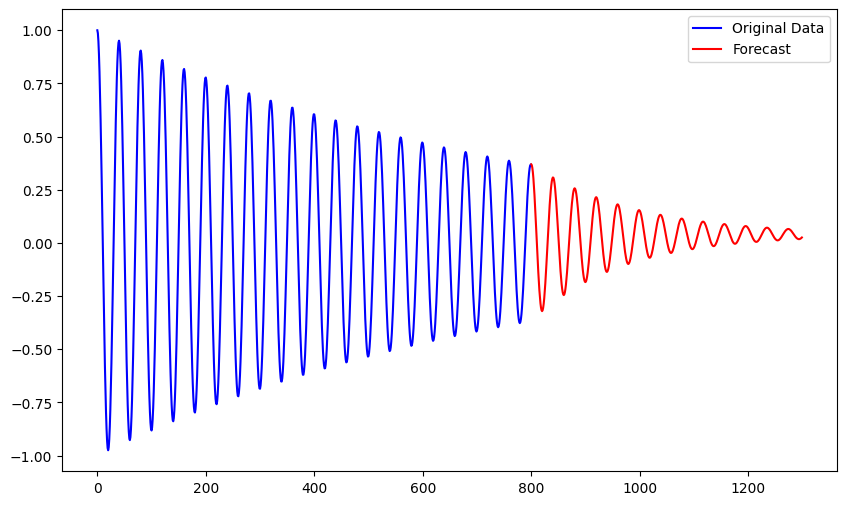

In [ ]:
forecast(model, train_dataset, time_series, forecast_step = 500, differencing = differencing)

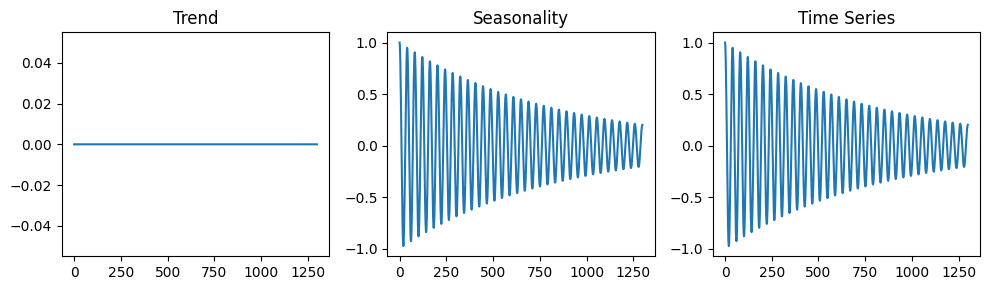

In [ ]:
time_series = generate_time_series_2(end = 16, n_steps = 1300, trend_noise_scale = 0.0, alpha = 1., )
plot_time_series(time_series, )